### Attribute Description:
Attribute | Description
----------|-------------
`Invoice No` | Invoice ID, encoded as Label
`StockCode` | Unique code per stock, encoded as Label
`Description` | The Description, encoded as Label
`Quantity` | Quantity purchased
`InvoiceDate` | Date of purchase
`UnitPrice` | The target value, price of every product
`CustomerID` | Unique Identifier for every country
`Country` | Country of sales, encoded as Label

### Target
`UnitPrice` is the target.

### Performance Measure
RMSE (Root Mean Square Error)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import preprocessing

## Initial Data Analysis

In [2]:
data = pd.read_csv("data/Train.csv")

In [3]:
test = pd.read_csv("data/Test.csv")

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [5]:
print("Shape of:")
print("-"*10)
print("\t Training data:", data.shape)
print("\t Test data:", test.shape)

Shape of:
----------
	 Training data: (284780, 8)
	 Test data: (122049, 7)


### Drop duplicates

In [6]:
print(f"There are {data[data.duplicated(keep=False)].shape[0]} duplicates in training data")

There are 5093 duplicates in training data


In [7]:
data = data.drop_duplicates(ignore_index=True)

### Missing Value Check and Type casting

In [8]:
print("Number of Nulls in Training data:",
      data.isna().sum()\
      .sum())

Number of Nulls in Training data: 0


In [9]:
print("Number of Nulls in Test data:",
        test.isna().sum()\
        .sum())

Number of Nulls in Test data: 0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282159 entries, 0 to 282158
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    282159 non-null  int64  
 1   StockCode    282159 non-null  int64  
 2   Description  282159 non-null  int64  
 3   Quantity     282159 non-null  int64  
 4   InvoiceDate  282159 non-null  object 
 5   UnitPrice    282159 non-null  float64
 6   CustomerID   282159 non-null  float64
 7   Country      282159 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 17.2+ MB


In [11]:
###### change dtypes to appropriate data types as applicable #######
categorical_cols = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

# convert to string
data[categorical_cols] = data.loc[:,categorical_cols].astype('object')
# convert to datetime
data['InvoiceDate'] = pd.to_datetime(data.loc[:,'InvoiceDate'])

In [12]:
data.describe()
# drop(columns=['year','month','day_of_week','hour','minutes','day_of_month']).describe()

,Quantity,UnitPrice
count,282159.000000,282159.000000
mean,12.109885,3.460501
std,296.463809,78.762448
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


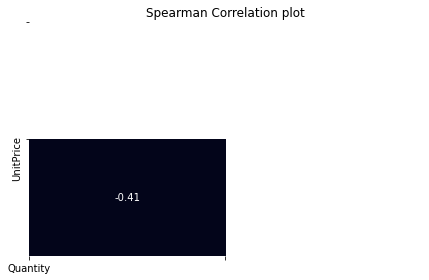

In [45]:
# corr = data[['Quantity', 'UnitPrice']].corr(method='spearman')
corr = data.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, mask=mask, cbar=False)


plt.title("Spearman Correlation plot")
plt.tight_layout()
plt.xticks(ticks=[0,1], labels=['Quantity', ''], )
plt.yticks(ticks=[0,1], labels=['','UnitPrice'])
plt.show()

### Observations

- There were $5093$ duplicate records in training data taht have been dropped.
- No missing values have been found.
- Both `Quantity` and `UnitPrice` have outliers. The severity of which needs to be further analysed. Although we will be limited in our ability to deal with outliers in `UnitPrice` since it is the target.
- Minimum for `Quantity` is -80995 which seems improbable and also observe that maximum is 80995. It will be further analysed.

# Engineer Temporal Features from `InvoiceDate`

In [31]:
data['year'] = data.InvoiceDate.dt.year
data['month'] = data.InvoiceDate.dt.month
data['day'] = data.InvoiceDate.dt.dayofweek # Monday=0, Sunday=6
data['hour'] = data.InvoiceDate.dt.hour
data['minutes'] = data.InvoiceDate.dt.minute
data['day_of_month'] = data.InvoiceDate.dt.day

In [32]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minutes,day_of_month
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056,35,2011,5,4,16,54,6
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098,35,2011,5,2,7,35,11
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044,35,2011,11,6,13,20,20
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525,35,2011,11,1,12,7,22
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952,35,2011,5,4,9,0,6


## General Hypothesis

#### $Q$: Does every Invoice has only one Associated customer?
$A:$ Yes every Invoice has only one unique customer associated with it. As shown below:

In [178]:
# No of unique InvoiceID
print("Number of unique invoices: ", data.InvoiceNo.nunique())

print('-'*70)

print("Number of Invoices with Number of unique customers !=1 :",
     (data.groupby('InvoiceNo')['CustomerID'].nunique() != 1).sum()
     )


Number of unique invoices:  20971
----------------------------------------------------------------------
Number of Invoices with Number of unique customers !=1 : 0


# UNivariate ANalysis of Variables

## `UnitPrice` $\Longrightarrow$  Target variable

In [54]:
data.UnitPrice.describe()

count    282159.000000
mean          3.460501
std          78.762448
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

In [141]:
# iqr 
# UNITPrice
q1, q3 = np.percentile(data.UnitPrice, [25, 75])
UP_iqr = q3 - q1
UP_max_threshold = q3 + 1.5 * UP_iqr

## LOG of UnitPrice
q1, q3 = np.percentile(np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.0001)),
                       [25, 75])
iqr = q3 - q1

log_max_threshold = q3 + 1.5 * iqr
log_median = np.percentile(np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.0001)),
                      50)

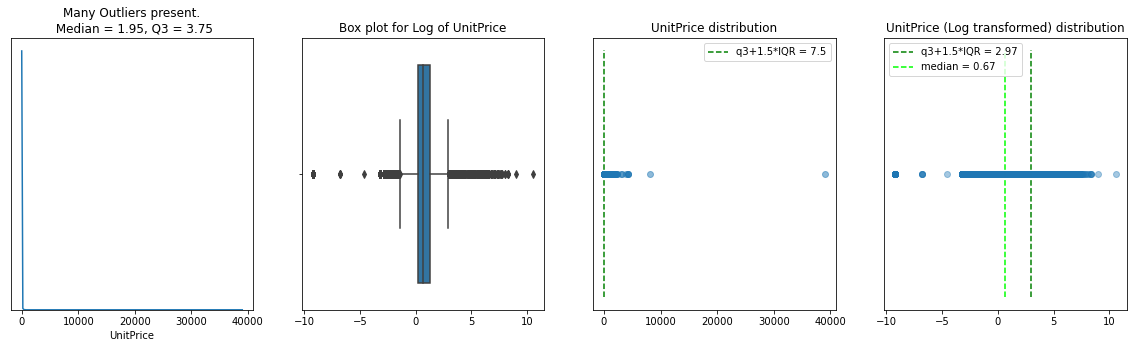

In [150]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))


plt.subplot(ax[0])
# sns.boxplot(x=data.UnitPrice)
sns.kdeplot(x=data.UnitPrice)
plt.yticks([])
plt.ylabel('')
plt.title("Many Outliers present.\n Median = 1.95, Q3 = 3.75")

plt.subplot(ax[1])
sns.boxplot(x=np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.0001)))
plt.xlabel('')
plt.title("Box plot for Log of UnitPrice")


plt.subplot(ax[2])
plt.plot(data.UnitPrice, np.ones_like(data.UnitPrice),
         'o', alpha=0.5)

plt.vlines(UP_max_threshold, 0.96, 1.04, linestyles='dashed', colors='g', label='q3+1.5*IQR = 7.5')
plt.yticks([])
plt.legend()
# plt.xlim(right=5000)
plt.title("UnitPrice distribution")

plt.subplot(ax[3])
plt.plot(np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.0001)),
         np.ones_like(data.UnitPrice),
         'o', alpha=0.4, linewidth=0.5)

plt.vlines(log_max_threshold, 0.96, 1.04, linestyles='dashed', colors='g', label=f'q3+1.5*IQR = {round(max_threshold,2)}')
plt.vlines(log_median, 0.96, 1.04, linestyles='dashed', colors='lime', label=f'median = {round(median,2)}')
plt.yticks([]) # remove y-ticks  
plt.legend(loc='upper left')
# plt.xlim(right=5000)
plt.title(f"UnitPrice (Log transformed) distribution")

plt.show()

In [144]:

a = np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.0001))

print(f"{round(len(data.UnitPrice[data.UnitPrice>UP_max_threshold])/len(data.UnitPrice) * 100,0)}\
% of observations are above Max threshold in UnitPrice")

print(f"{round(len(a[a>log_max_threshold])/len(a) * 100,2)}\
% of observations are above Max threshold in Log of UnitPrice")


9.0% of observations are above Max threshold in UnitPrice
0.37% of observations are above Max threshold in Log of UnitPrice


### Observation from analysis of `UnitPrice`

- Taking Log reduced the Outliers from $\approx 9\%$ to $0.37\%$.
- Log transformation will be used on UnitPrice, $\because$ it reduces the number of outliers significantly.


In [151]:
# jitter added
data['log_UnitPrice'] = np.log(data.UnitPrice + np.full_like(data.UnitPrice, fill_value=0.01))

## `Quantity`
From above Initaial analysis wkt. there are some discrepencies in Quantity values. We will explore them in depth.

In [154]:
print(f"Number records where quantity is zero: {data[data.Quantity==0].shape[0]}")
print(f"Number of records where quantity < zero: {data[data.Quantity<0].shape[0]}")

Number records where quantity is zero: 0
Number of records where quantity < zero: 6153


### Analysing `-ve` order Quantities
Possibilities are that the negative quantities are either
- mistakenly recorded as negative quantity or
- result of negative proration such as  return orders [(refer)](https://knowledgecenter.zuora.com/BB_Introducing_Z_Business/How_Do_I_._._./How_do_I_handle_a_negative_invoice%3F).

It has been noticed that negative quantities are present even in the test set, thus reducing the chances of it being being data entry error.\
This also takes away the possibility of dropping such records from analysis. Although the negative quatities are very small fraction of both the training as well as test datasets(as shown below).

In [109]:
print("Percentage of observations with negative quantity in Training data:",
     round(data[data.Quantity < 0].shape[0] / data.shape[0] * 100
         ,2)
     )

print("-"*100)

print("Percentage of observations with negative quantity in Test data:",
     round(test[test.Quantity < 0].shape[0] / test.shape[0] * 100
         ,2)
     )

Percentage of observations with negative quantity in Training data: 2.18
----------------------------------------------------------------------------------------------------
Percentage of observations with negative quantity in Test data: 2.24


In [95]:
data['Quantity_pos'] = data.Quantity.apply(lambda x: 'POS' if x>=0 else 'NEG')

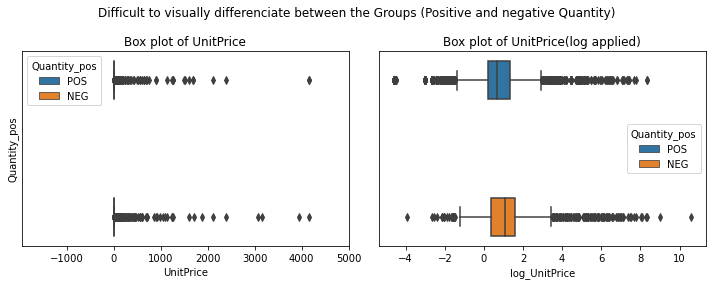

In [118]:
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharey=True)
plt.subplot(ax[0])
sns.boxplot(y='Quantity_pos', x='UnitPrice', data=data, hue='Quantity_pos')
plt.xlim(right=5000)
plt.title("Box plot of UnitPrice")

plt.subplot(ax[1])
sns.boxplot(y='Quantity_pos', x='log_UnitPrice', data=data, hue='Quantity_pos')
plt.ylabel('')
plt.yticks([])
plt.title("Box plot of UnitPrice(log applied)")

plt.suptitle("Difficult to visually differenciate between the Groups (Positive and negative Quantity)")

plt.tight_layout()
plt.show()

In [97]:
data.groupby('Quantity_pos')['UnitPrice'].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
Quantity_pos,,,,,,,,
NEG,6153.0,20.599,521.433,0.01,1.45,2.95,4.95,38970.00
POS,276006.0,3.078,16.577,0.00,1.25,1.95,3.75,4161.06


#### Statistical test (Mann-Whitney U Test)

- Although Relationship is not exactly Linear (that would indicate Normal distribution), but it is Linear enough give the large sample size.
- Levene's test of Homogeneity of variance is violated. But if ratio of Largest: Smallest group is reasonable ($\approx$ 1.5 times), then violation of this assumption should not cause any major issue.However, the ratio is too high ($\approx$ 45 times). Thus violation is serious.

Keeping in view above points the Non - parametric variant of the t-test, **Mann-Whitney U Test** is used.

##### Normality test

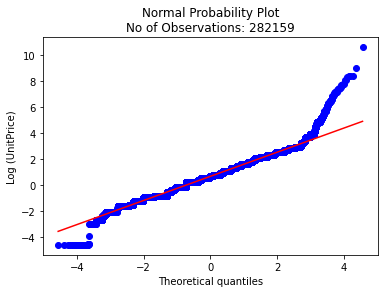

In [127]:
stats.probplot(data.log_UnitPrice, plot=plt)
plt.title(f"Normal Probability Plot\nNo of Observations: {data.log_UnitPrice.shape[0]}")
plt.ylabel("Log (UnitPrice)")
plt.show()

##### Levene's test of Homogeneity

In [130]:
stat, p = stats.levene(data.UnitPrice[data.Quantity_pos=='POS'],
                      data.UnitPrice[data.Quantity_pos=='NEG'])

In [134]:
is_significant = lambda p_value: 'Significant' if p_value<=0.05 else 'NOT Significant'
print(f"Levenes test is {is_significant(p)}, with p = {round(p, 4)}.")

if is_significant(p).strip().lower() == 'significant':
    print("Thus, assumption of Homogeneity of Variance is Violated.")
else:
    print("Thus, assumption of Homogeneity of Variance is Not violated. ")

Levenes test is Significant, with p = 0.0.
Thus, assumption of Homogeneity of Variance is Violated.


In [139]:
print(f"Ratio of Largest: Smallest = \
{round(data[data.Quantity_pos=='POS'].shape[0]/data[data.Quantity_pos=='NEG'].shape[0],0)}"
)

Ratio of Largest: Smallest = 45.0


##### Mann-Whitney U Test
$H_0$: The distribution of UnitPrice is **same across categories** ie. POS and NEG Quantitites.\
$H_a$: The distribution of UnitPrice is **not same across categories** ie. POS and NEG Quantitites.

In [141]:
stat, p = stats.mannwhitneyu(x=data.UnitPrice[data.Quantity_pos=='POS'], 
                   y=data.UnitPrice[data.Quantity_pos=='NEG'],
                   alternative='two-sided')

In [146]:
if p < 0.05:
    print(f"Mann-Whitney test is Significant (p={round(p, 4)}), meaning the distribution of UnitPrice is sepearate across groups.")
else:
    print(f"The test is Not significant (p={round(p, 4)}), meaning the distribution of UnitPrice is same across groups. ")

Mann-Whitney test is Significant (p=0.0), meaning the distribution of UnitPrice is sepearate across groups.


#### Observation from Quantities divided into POS and NEG categories

- Negative quantities are result of **negative proration**.
- There is **statistically significant difference** in distribution of UnitPrice for **Postive and negative quantities**.
- Thus `Quantity_pos` **may** prove to be a **useful feature** to any future predcitive model.

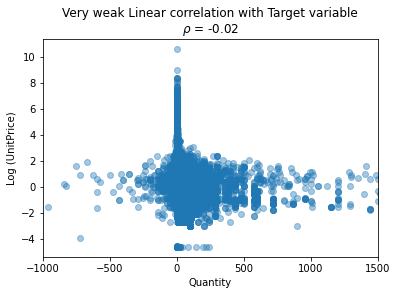

In [209]:
# plt.scatter(data.Quantity, np.log(data.UnitPrice+np.full_like(data.UnitPrice, fill_value=0.001)))
plt.scatter(data.Quantity, data.log_UnitPrice, alpha=0.4)
plt.xlabel('Quantity')
plt.ylabel("Log (UnitPrice)")
plt.xlim(-1000, 1500)
rho = r"$\rho$"
plt.title(f"Very weak Linear correlation with Target variable\n{rho} = {round(stats.pearsonr(data.Quantity, data.log_UnitPrice)[0], 2)}")
plt.show()

C:\Users\MY - PC\anaconda3\envs\abusive_language_detection\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Quantity'>

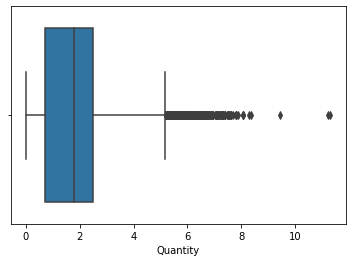

In [234]:
sns.boxplot(np.log(data.Quantity))

In [236]:
quant_YJ = preprocessing.PowerTransformer().fit_transform(data.Quantity.values.reshape(-1,1))

In [253]:
pd.Series(quant_YJ.reshape(len(quant_YJ))).isna().sum()

0

In [260]:
np.median(data.Quantity)

5.0

In [261]:
def median_transformation(variable):
    '''
         z = (x - u) / s
    '''
    median = np.median(variable)
    mad = stats.median_abs_deviation(variable, nan_policy='omit')
    
    return pd.Series(variable).apply(lambda x: (x-median)/mad)
    

In [262]:
quant_med_scaled = median_transformation(data.Quantity)

(-50.0, 50.0)

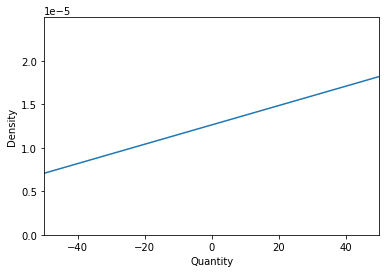

In [264]:
sns.kdeplot(quant_med_scaled)
plt.xlim(-50, 50)

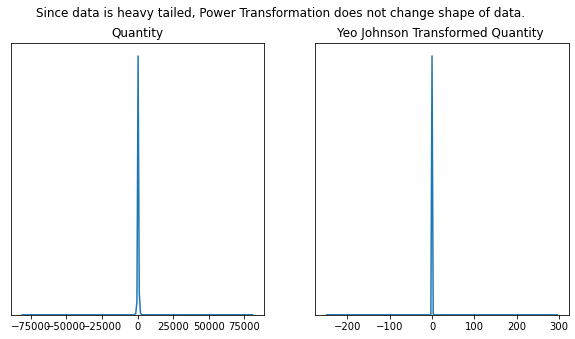

In [259]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plt.subplot(ax[0])
sns.kdeplot(data.Quantity)
plt.title("Quantity")
plt.yticks([])
plt.ylabel('')
plt.xlabel('')

plt.subplot(ax[1])
sns.kdeplot(quant_YJ.reshape(len(quant_YJ)))
plt.title("Yeo Johnson Transformed Quantity ")
plt.yticks([])
plt.ylabel('')
plt.xlabel('')

plt.suptitle("Since data is heavy tailed, Power Transformation does not change shape of data.")
plt.show()

C:\Users\MY - PC\anaconda3\envs\abusive_language_detection\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Quantity'>

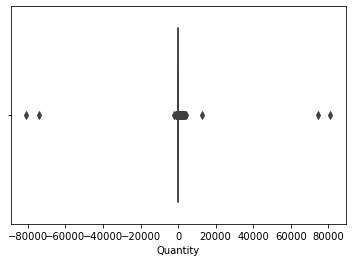

In [165]:
sns.boxplot(data.Quantity)

In [169]:
q1, quant_median, q3 = np.percentile(data.Quantity, [25, 50, 75])
quant_IQR = q3 - q1

quant_min_threshold = q1 - 1.5*quant_IQR
quant_max_threshold = q3 + 1.5*quant_IQR

# LOG
log_quantity = np.log(data.Quantity + np.full_like(data.Quantity, fill_value=0.0001))
q1, log_quant_median, q3 = np.percentile(log_quantity, [25, 50, 75])
log_quant_IQR = q3 - q1

log_quant_min_threshold = q1 - 1.5*log_quant_IQR
log_quant_max_threshold = q3 + 1.5*log_quant_IQR

# SCALED
scaled_quantity = preprocessing.RobustScaler().fit_transform(data.Quantity.values.reshape(-1,1))
q1, scaled_quant_median, q3 = np.percentile(scaled_quantity, [25, 50, 75])
scaled_quant_IQR = q3 - q1

scaled_quant_min_threshold = q1 - 1.5*scaled_quant_IQR
scaled_quant_max_threshold = q3 + 1.5*scaled_quant_IQR


C:\Users\MY - PC\anaconda3\envs\abusive_language_detection\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


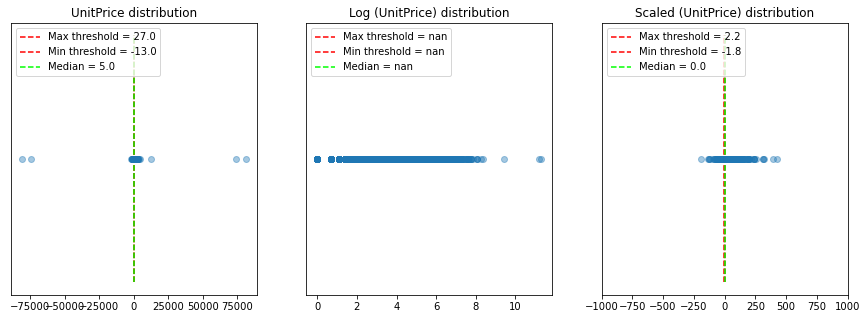

In [191]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

# 
plt.subplot(ax[0])
plt.plot(data.Quantity, np.ones_like(data.Quantity), 
        'o', alpha=0.4, linewidth=0.5)
plt.vlines(quant_max_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Max threshold = {round(quant_max_threshold, 2)}")
plt.vlines(quant_min_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Min threshold = {round(quant_min_threshold, 2)}")
plt.vlines(quant_median, 0.96, 1.04, linestyles='dashed',
           colors='lime', label=f"Median = {round(quant_median, 2)}")

plt.yticks([]) # remove y-ticks  
plt.legend(loc='upper left')
plt.title(f"UnitPrice distribution")


# Log Transformed
plt.subplot(ax[1])
plt.plot(log_quantity, np.ones_like(log_quantity),
         'o', alpha=0.4, linewidth=0.5)
plt.vlines(log_quant_max_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Max threshold = {round(log_quant_max_threshold, 2)}")
plt.vlines(log_quant_min_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Min threshold = {round(log_quant_min_threshold, 2)}")
plt.vlines(log_quant_median, 0.96, 1.04, linestyles='dashed',
           colors='lime', label=f"Median = {round(log_quant_median, 2)}")

plt.yticks([]) # remove y-ticks  
plt.legend(loc='upper left')
plt.title(f"Log (UnitPrice) distribution")



# Robust Scaled
plt.subplot(ax[2])
plt.plot(scaled_quantity, np.ones_like(scaled_quantity),
         'o', alpha=0.4, linewidth=0.5)
plt.vlines(scaled_quant_max_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Max threshold = {round(scaled_quant_max_threshold, 2)}")
plt.vlines(scaled_quant_min_threshold, 0.96, 1.04, linestyles='dashed',
           colors='r', label=f"Min threshold = {round(scaled_quant_min_threshold, 2)}")
plt.vlines(scaled_quant_median, 0.96, 1.04, linestyles='dashed',
           colors='lime', label=f"Median = {round(scaled_quant_median, 2)}")

plt.yticks([]) # remove y-ticks  
plt.xlim(-1000, 1000)
plt.legend(loc='upper left')
plt.title(f"Scaled (UnitPrice) distribution")



plt.show()

# plt.vlines(log_quant_max_threshold, 0, 1, linestyles='dashed', colors='g', label=f'q3+1.5*IQR = {round(max_threshold,2)}')
# plt.vlines(log_quant_median, 0.96, 1.04, linestyles='dashed', colors='lime', label=f'median = {round(median,2)}')
# plt.yticks([]) # remove y-ticks  
# plt.legend(loc='upper left')
# # plt.xlim(right=5000)
# plt.title(f"UnitPrice (Log transformed) distribution")


<AxesSubplot:ylabel='Frequency'>

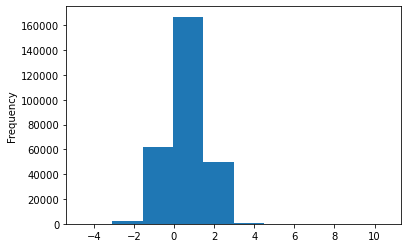

In [129]:
data.log_UnitPrice.plot(kind='hist')

## `Country`

In [18]:
print(f"There are data from {data.Country.nunique()} countries.")

There are data from 37 countries.


In [12]:
data.InvoiceNo.nunique()

20971

In [14]:
len(set(data.InvoiceNo.unique())\
    .intersection(set(test.InvoiceNo.unique()))
   )

16985

In [26]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [41]:
# data.rename(columns={'day':'day_of_week'}, inplace=True)


In [36]:
data.Description.nunique()

3819

In [59]:
data[data.InvoiceNo==6141].shape

(34, 14)

In [43]:
data[data.InvoiceNo==6141]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day_of_week,hour,minutes,day_of_month
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,2011,5,4,16,54,6
20741,6141,1893,2683,3,2011-05-06 16:54:00,8.25,14056.0,35,2011,5,4,16,54,6
21318,6141,2106,1023,1,2011-05-06 16:54:00,7.95,14056.0,35,2011,5,4,16,54,6
35092,6141,1272,1988,2,2011-05-06 16:54:00,1.25,14056.0,35,2011,5,4,16,54,6
54221,6141,2626,1017,1,2011-05-06 16:54:00,7.95,14056.0,35,2011,5,4,16,54,6
63730,6141,2033,1762,1,2011-05-06 16:54:00,2.08,14056.0,35,2011,5,4,16,54,6
66639,6141,170,1953,1,2011-05-06 16:54:00,1.65,14056.0,35,2011,5,4,16,54,6
77522,6141,1894,2688,3,2011-05-06 16:54:00,8.25,14056.0,35,2011,5,4,16,54,6
77652,6141,2035,1761,1,2011-05-06 16:54:00,2.08,14056.0,35,2011,5,4,16,54,6
94976,6141,1473,2245,6,2011-05-06 16:54:00,0.29,14056.0,35,2011,5,4,16,54,6


# Basic Mean modelling

In [38]:
data.UnitPrice.mean()

3.46050097285573

In [ ]:
predicted = 